In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')

Link to the dataset: https://www.kaggle.com/competitions/bike-sharing-demand/data

Note that we won't use their testing set that does not contain the target variable. We will only use the training set.

In [44]:
df = pd.read_csv('train.csv')

In [46]:
df.head(100)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2011-01-05 04:00:00,1,0,1,1,9.84,11.365,48,15.0013,0,2,2
96,2011-01-05 05:00:00,1,0,1,1,9.02,11.365,47,11.0014,0,3,3
97,2011-01-05 06:00:00,1,0,1,1,8.20,9.850,47,15.0013,0,33,33
98,2011-01-05 07:00:00,1,0,1,1,7.38,9.090,43,12.9980,1,87,88


In [3]:
print("\n--- Statistical Summary ---")
print(df.describe())


--- Statistical Summary ---
             season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.2450

df.info(): The datetime column is an object (a string). We will need to convert this to a datetime object to extract time-based features. The best news is that there are no missing (null) values, which simplifies our data cleaning.

df.describe(): We can see the range of our target variable count is from 1 to 977. We also see that windspeed has a minimum of 0.0, which is suspicious and might indicate missing data (it's rare for there to be absolutely no wind). The temp and atemp features have very similar means and standard deviations, hinting they are highly correlated. Keep in mind the data is always from 1st to 19th (the test data which we do not use is from 20th to 31st).

# EDA

## Target variable

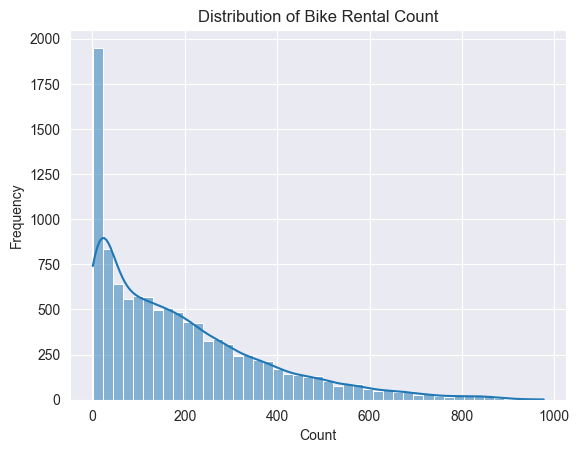

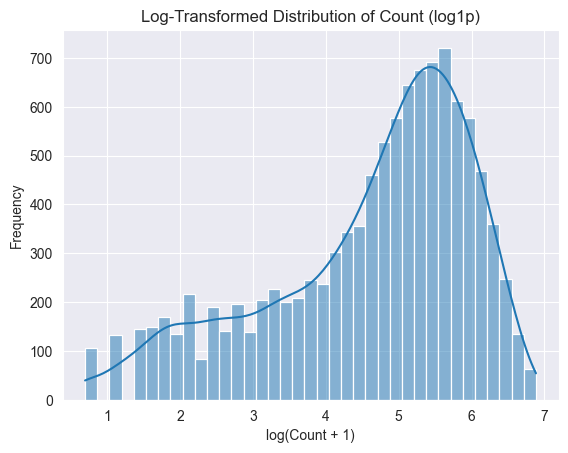

In [4]:
# Convert datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Plot distribution of 'count'
sns.histplot(df['count'], kde=True)
plt.title('Distribution of Bike Rental Count')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

# Plot distribution of 'log1p(count)'
sns.histplot(np.log1p(df['count']), kde=True)
plt.title('Log-Transformed Distribution of Count (log1p)')
plt.xlabel('log(Count + 1)')
plt.ylabel('Frequency')
plt.show()

count Distribution: The first histogram is highly skewed. This means most rental hours have low counts, with a "long tail" of a few hours having very high counts. Standard linear models perform poorly on such skewed data.

Log-Transformed count: The np.log1p(count) plot transforms the data and makes it look much more like a normal distribution (a bell curve). This is a strong confirmation that our models will be more stable and accurate if they are trained to predict the logarithm of the count, not the count itself. This also explains why the competition uses the RMSLE metric.

## Univariate analysis

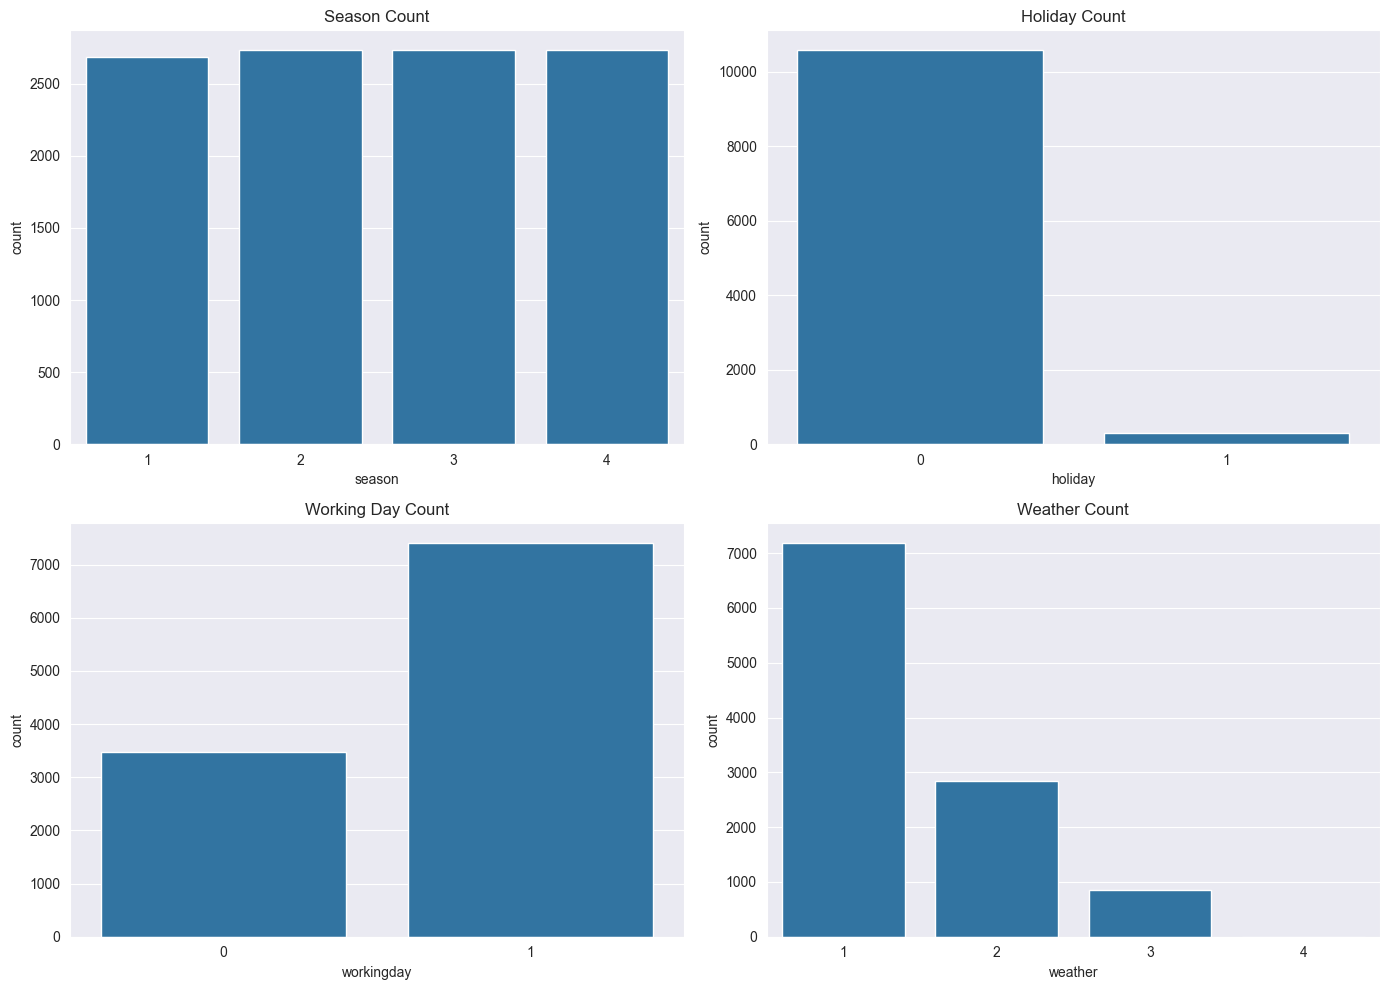

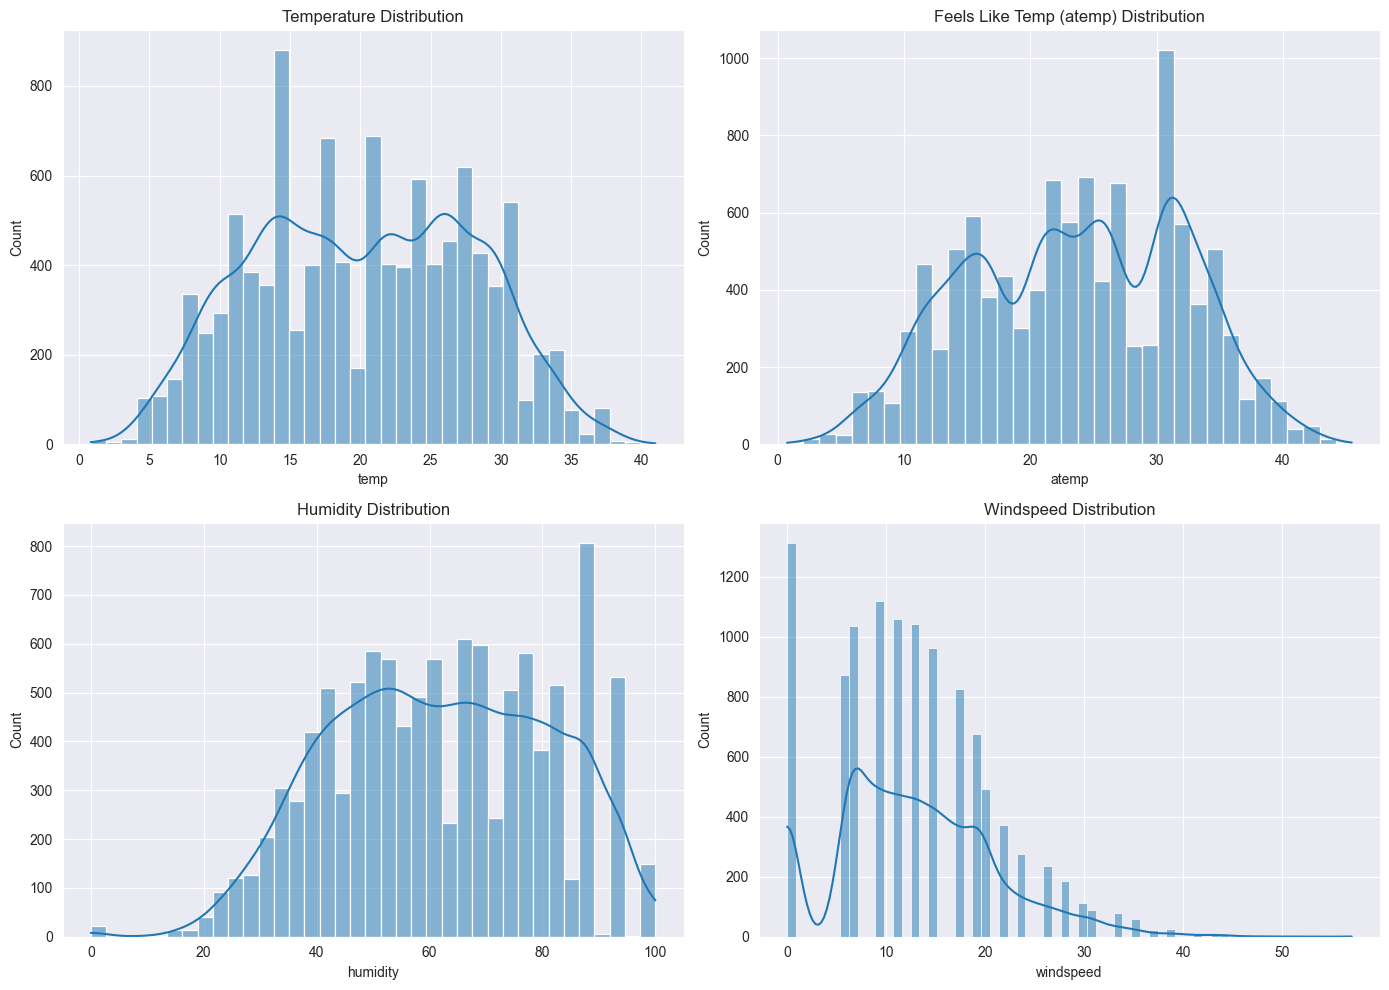

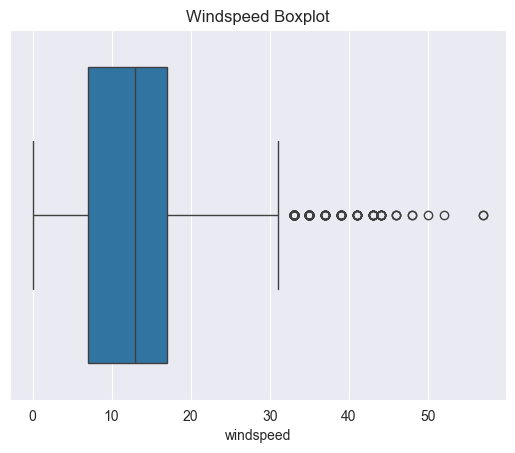

In [5]:
# Categorical Features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.countplot(data=df, x='season', ax=axes[0, 0]).set_title('Season Count')
sns.countplot(data=df, x='holiday', ax=axes[0, 1]).set_title('Holiday Count')
sns.countplot(data=df, x='workingday', ax=axes[1, 0]).set_title('Working Day Count')
sns.countplot(data=df, x='weather', ax=axes[1, 1]).set_title('Weather Count')
plt.tight_layout()
plt.show()

# Numerical Features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(df['temp'], kde=True, ax=axes[0, 0]).set_title('Temperature Distribution')
sns.histplot(df['atemp'], kde=True, ax=axes[0, 1]).set_title('Feels Like Temp (atemp) Distribution')
sns.histplot(df['humidity'], kde=True, ax=axes[1, 0]).set_title('Humidity Distribution')
sns.histplot(df['windspeed'], kde=True, ax=axes[1, 1]).set_title('Windspeed Distribution')
plt.tight_layout()
plt.show()

# Boxplot for Windspeed
sns.boxplot(data=df, x='windspeed')
plt.title('Windspeed Boxplot')
plt.show()

Categorical Plots: The season and workingday features are fairly well-balanced. However, holiday and weather are highly imbalanced. Very few entries are holidays (1), and almost none are weather=4 (heavy storm). This scarcity means weather=4 will be very difficult for a model to learn from.

Numerical Plots: temp and atemp are smooth, normal-like distributions. humidity is also well-distributed. The windspeed plot clearly confirms our suspicion: there is a large, unnatural spike at 0, which strongly suggests this is missing data that was entered as "0". We will need to handle this in feature engineering.

## Bivariate analysis (Features vs. count)

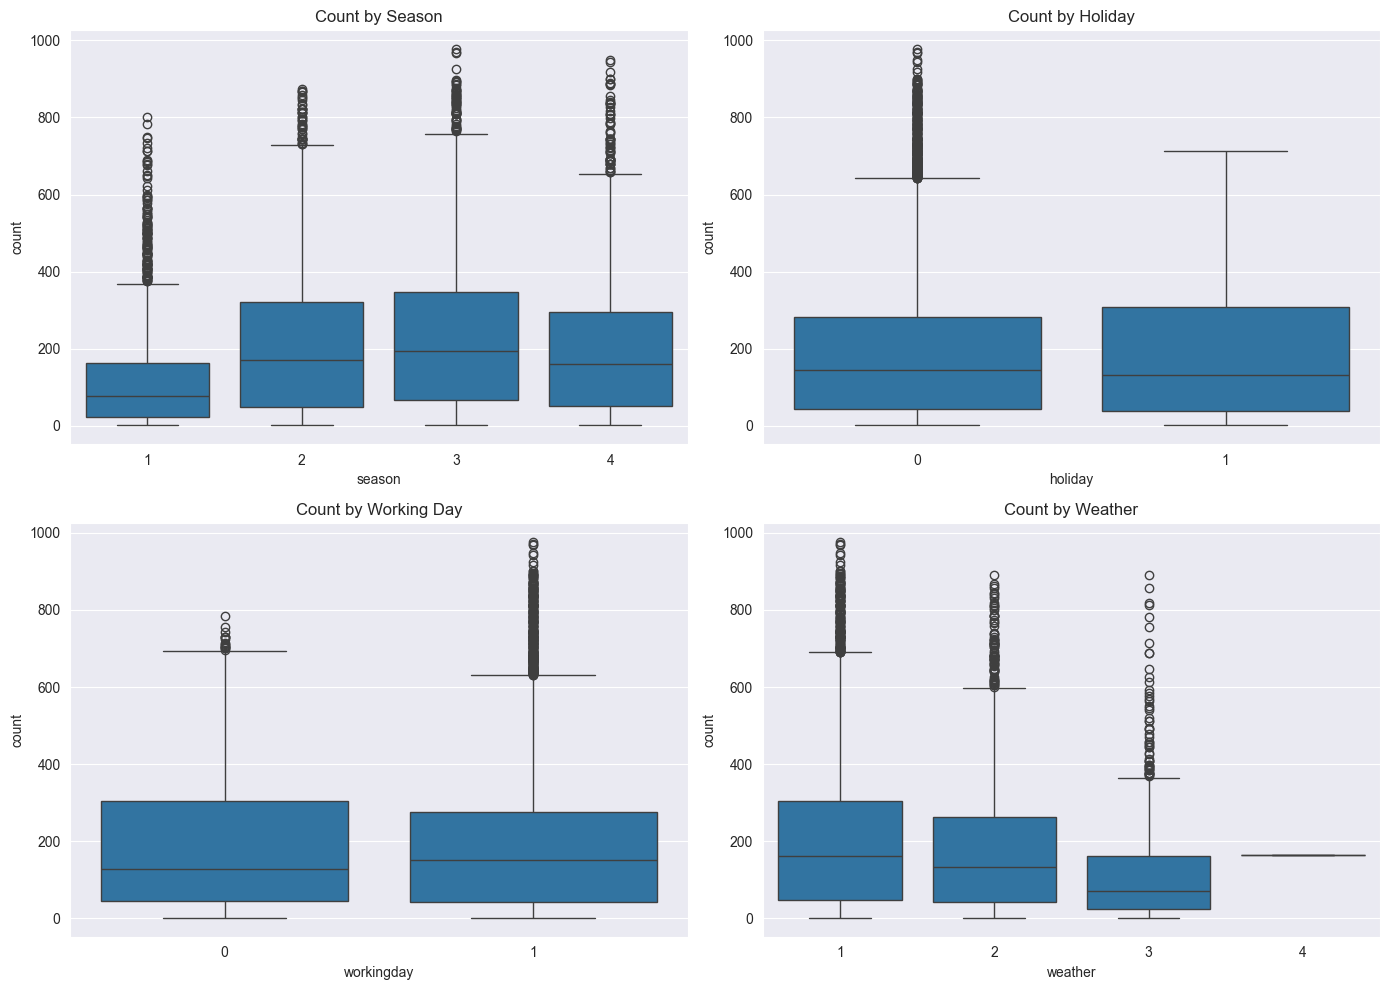

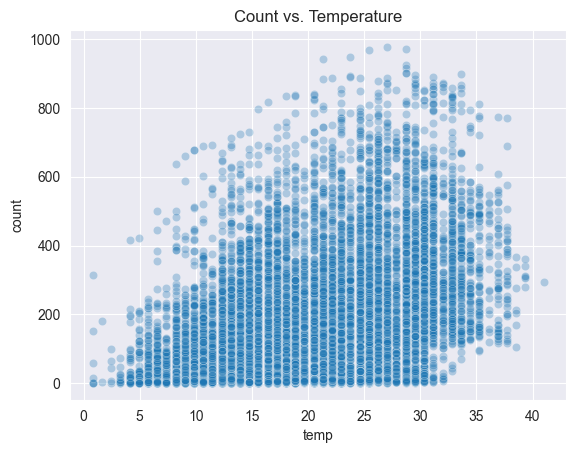

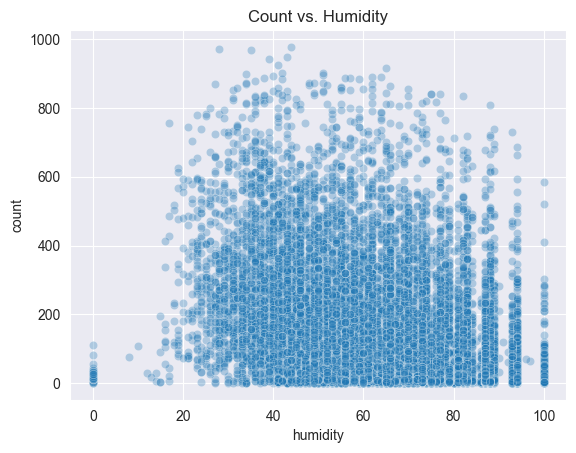

In [6]:
# Categorical Features vs. Count
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.boxplot(data=df, x='season', y='count', ax=axes[0, 0]).set_title('Count by Season')
sns.boxplot(data=df, x='workingday', y='count', ax=axes[1, 0]).set_title('Count by Working Day')
sns.boxplot(data=df, x='weather', y='count', ax=axes[1, 1]).set_title('Count by Weather')
sns.boxplot(data=df, x='holiday', y='count', ax=axes[0, 1]).set_title('Count by Holiday')
plt.tight_layout()
plt.show()

# Numerical Features vs. Count
sns.scatterplot(data=df, x='temp', y='count', alpha=0.3)
plt.title('Count vs. Temperature')
plt.show()

sns.scatterplot(data=df, x='humidity', y='count', alpha=0.3)
plt.title('Count vs. Humidity')
plt.show()

(!) I first found it weird to have less bike rentals in Spring (season=1) than in Winter (season=4). But actually, in this dataset, Spring = (Jan, Feb, March) and Winter = (Oct, Nov, Dec). So this pattern makes sense.

In [7]:
df[df['weather'] == 4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164


A single data point is not a pattern; it's a statistical anomaly or noise. A machine learning model cannot learn anything meaningful from one example. The model will either completely ignore it or, worse, overfit to it by creating a specific, useless rule just for that one row.

In [8]:
df['weather'] = df['weather'].replace(4, 3)

## Multivariate analysis -- Correlation and Time Series analysis

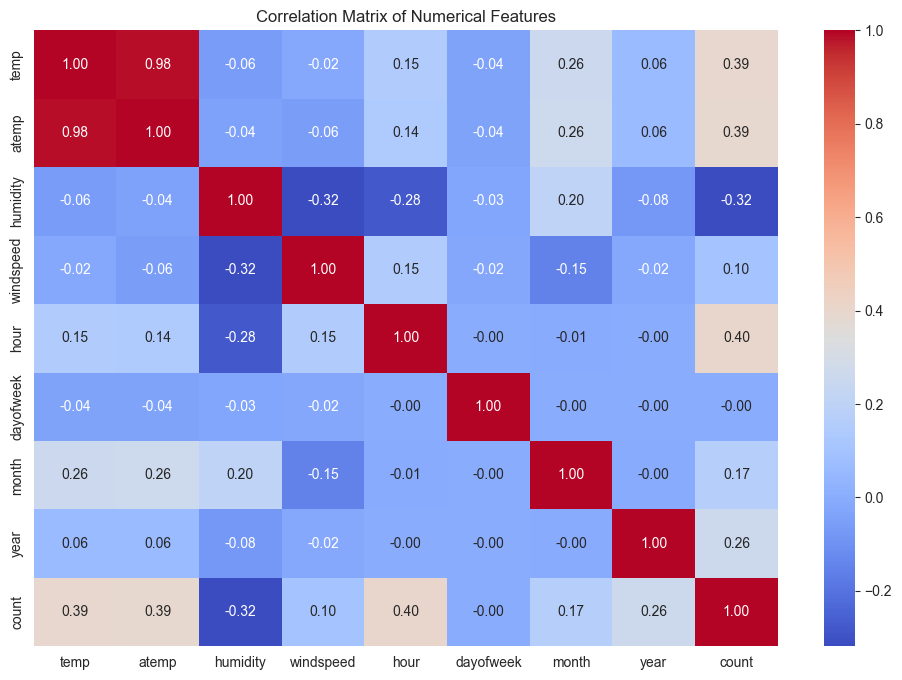

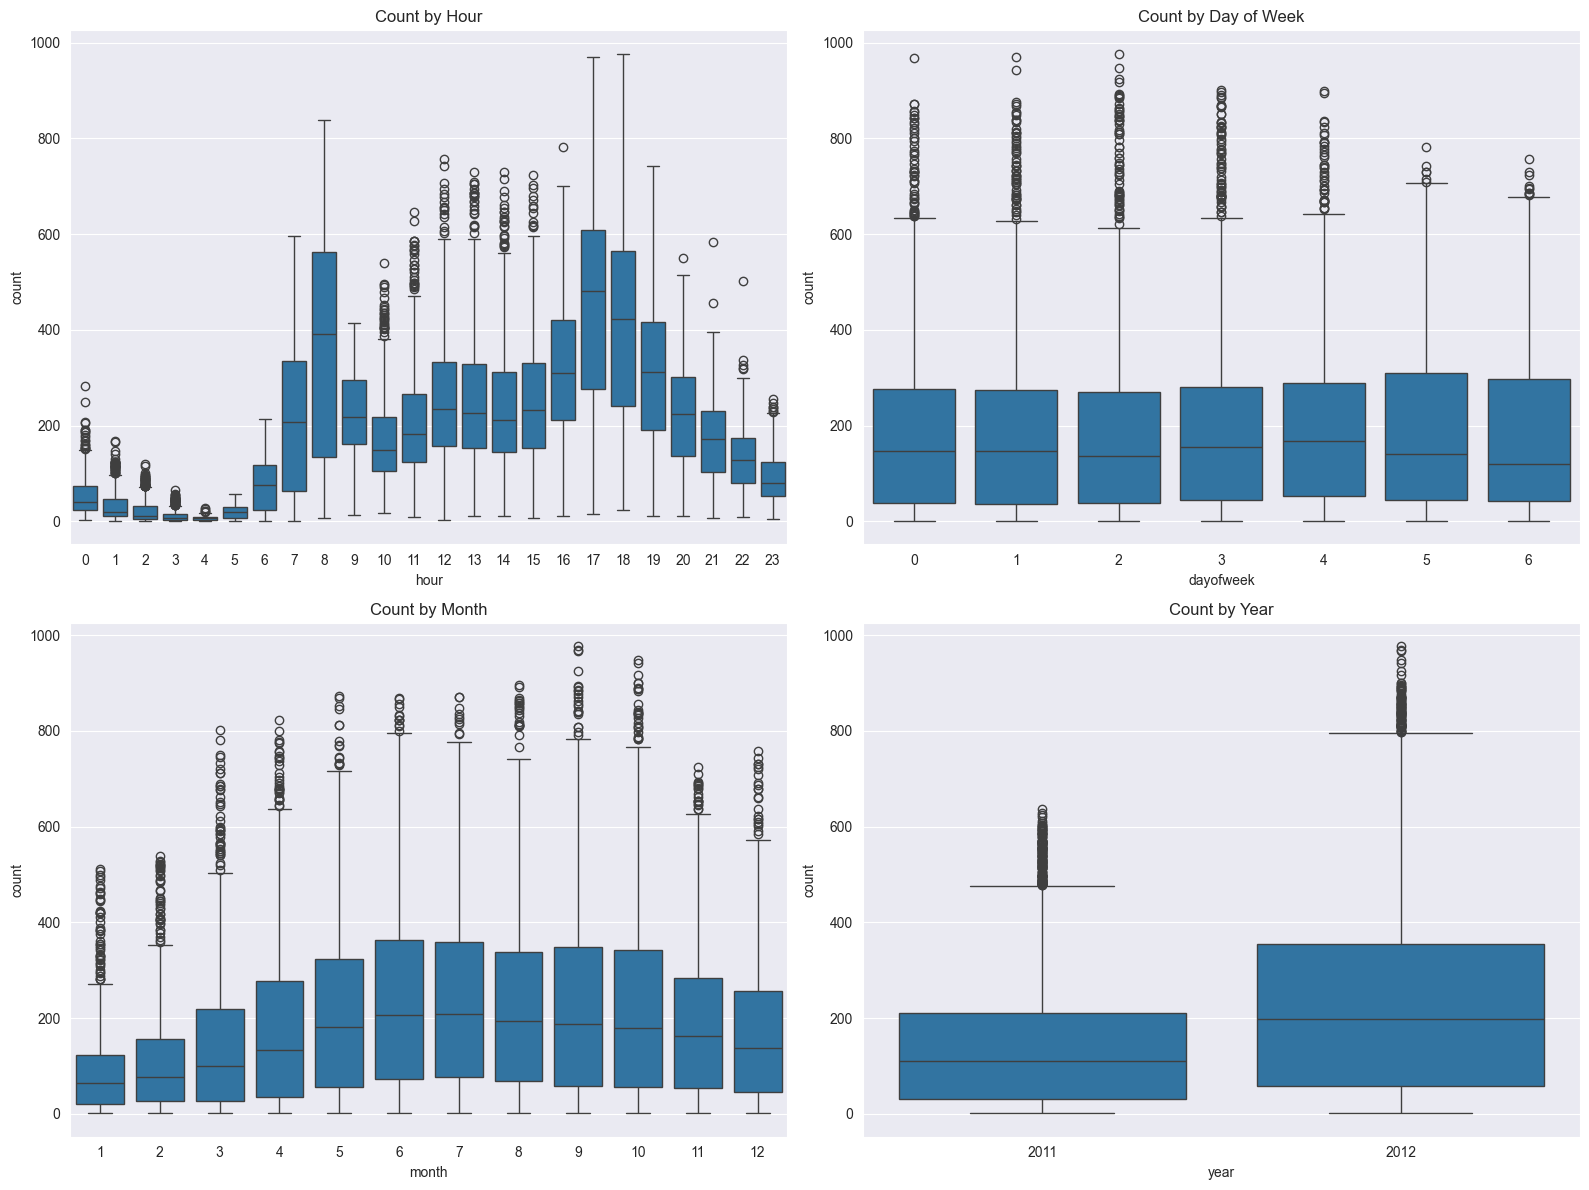

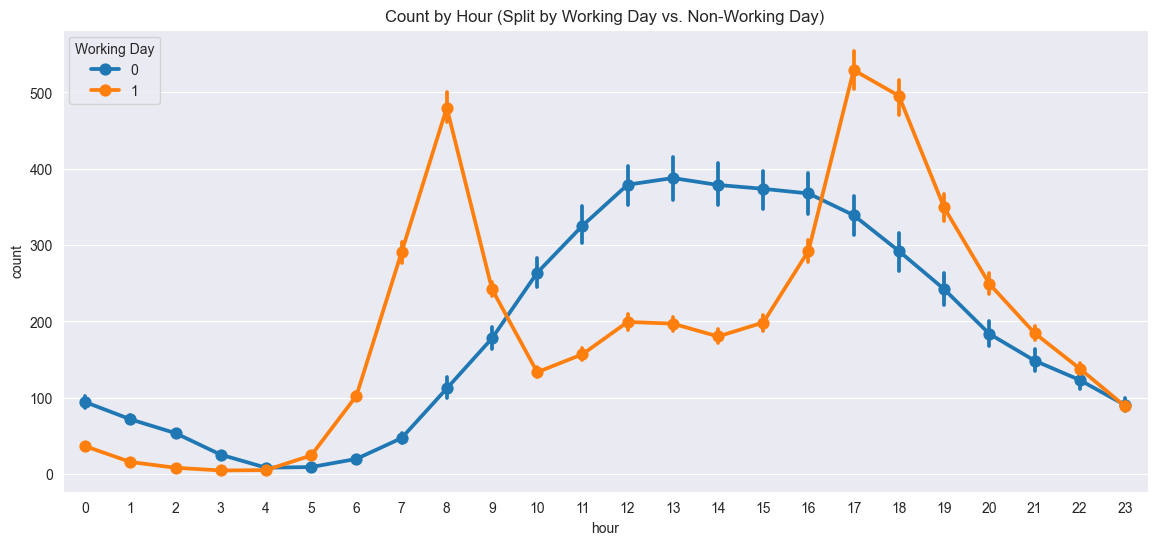

In [9]:
# Feature Engineering
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

# Correlation Heatmap
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed', 'hour',
                      'dayofweek', 'month', 'year', 'count']
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Time-Series Plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.boxplot(data=df, x='hour', y='count', ax=axes[0, 0]).set_title('Count by Hour')
sns.boxplot(data=df, x='dayofweek', y='count', ax=axes[0, 1]).set_title('Count by Day of Week')
sns.boxplot(data=df, x='month', y='count', ax=axes[1, 0]).set_title('Count by Month')
sns.boxplot(data=df, x='year', y='count', ax=axes[1, 1]).set_title('Count by Year')
plt.tight_layout()
plt.show()

# Interaction Plot (Hour vs. Count, split by Working Day)
plt.figure(figsize=(14, 6))
sns.pointplot(data=df, x='hour', y='count', hue='workingday')
plt.title('Count by Hour (Split by Working Day vs. Non-Working Day)')
plt.legend(title='Working Day', loc='upper left')
plt.show()

- Correlation Heatmap: This heatmap is very revealing.

-- temp and atemp have a ~0.98 correlation. This is almost perfect multicollinearity, meaning they are redundant. We must drop one of them (e.g, atemp) before modeling.

-- count is most positively correlated with temp and hour, and most negatively correlated with humidity.

- Interaction Plot: the relationship between hour and count is completely dependent on whether it's a workingday.

-- Working Days (1): Show a bimodal "W" shape, with sharp peaks at 8 AM and 5-6 PM. This is clearly commuter traffic.

-- Non-Working Days (0): Show a unimodal "bell curve," with a single, broad leisure peak in the afternoon (12 PM - 5 PM).

Overall Conclusion: This EDA proves our model must not treat hour and workingday as separate, independent features. The interaction between them is the key to accurately predicting demand.

# Modeling

## Feature Engineering

In [10]:
y_count = df['count']
# We log-transform the target variable for modeling, as discovered in EDA
y_log = np.log1p(y_count)

# Drop target variables (by the way we will not use 'registered' and 'casual')
df = df.drop(columns=['count', 'registered', 'casual'])

In [11]:
# Convert to datetime object
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract new features
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['dayofweek'] = df['datetime'].dt.dayofweek
df['day'] = df['datetime'].dt.day

# These variables are cyclical.
# OHE is not wrong, but it has a key weakness: it doesn't tell the model that hour_23 is right next to hour_0,
# or that month_12 (December) is right next to month_1 (January).
# So instead of OHE we will use sin/cos encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12.0)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12.0)

df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7.0)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7.0)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / 7.0)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 7.0)


df = df.drop(columns=[
    'hour', 'month', 'dayofweek', 'day'
])

# Drop 'atemp' due to high correlation with 'temp'
df = df.drop(columns=['atemp'])

In [12]:
categorical_features = ['season', 'holiday', 'workingday', 'weather']

# Apply one-hot encoding (get_dummies)
df = pd.get_dummies(df, columns=categorical_features, drop_first=False)

In [13]:
df.head()

,datetime,temp,humidity,windspeed,year,hour_sin,hour_cos,month_sin,month_cos,dayofweek_sin,...,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_1,weather_2,weather_3
0,2011-01-01 00:00:00,9.84,81,0.0,2011,0.000000,1.000000,0.5,0.866025,-0.974928,...,False,False,False,True,False,True,False,True,False,False
1,2011-01-01 01:00:00,9.02,80,0.0,2011,0.258819,0.965926,0.5,0.866025,-0.974928,...,False,False,False,True,False,True,False,True,False,False
2,2011-01-01 02:00:00,9.02,80,0.0,2011,0.500000,0.866025,0.5,0.866025,-0.974928,...,False,False,False,True,False,True,False,True,False,False
3,2011-01-01 03:00:00,9.84,75,0.0,2011,0.707107,0.707107,0.5,0.866025,-0.974928,...,False,False,False,True,False,True,False,True,False,False
4,2011-01-01 04:00:00,9.84,75,0.0,2011,0.866025,0.500000,0.5,0.866025,-0.974928,...,False,False,False,True,False,True,False,True,False,False


## Train and evaluate

We will explore two ways of performing cross validation with time series:

### Expanding windows

It's the most common and generally recommended starting point. In scikit-learn, this is implemented as TimeSeriesSplit.
- Fold 1: Train on [Block 1], Test on [Block 2]
- Fold 2: Train on [Block 1, Block 2], Test on [Block 3]
- Fold 3: Train on [Block 1, Block 2, Block 3], Test on [Block 4]
- ...and so on.

### Sliding windows

- Fold 1: Train on [Block 1, Block 2], Test on [Block 3]
- Fold 2: Train on [Block 2, Block 3], Test on [Block 4]
- Fold 3: Train on [Block 3, Block 4], Test on [Block 5]
- ...and so on.

Ideally, we would like to find a model which ranks the best regarding both these CV methods. This would make our final decision relatively safe.



In [29]:
models = {
    "Linear Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),

    "RF (n_estimators=100, max_depth=5)": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
    "RF (n_estimators=200, max_depth=5)": RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42, n_jobs=-1),
    "RF (n_estimators=100, max_depth=10)": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    "RF (n_estimators=200, max_depth=10)": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1),

    "GB (n_estimators=100, lr=0.1)": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "GB (n_estimators=200, lr=0.1)": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42),
    "GB (n_estimators=100, lr=0.05)": GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, random_state=42),
    "GB (n_estimators=200, lr=0.05)": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42),

    "MLP (layers=100,50)": Pipeline([
        ('scaler', StandardScaler()),
        ('model', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, early_stopping=True, random_state=42))
    ]),
    "MLP (layers=50,25)": Pipeline([
        ('scaler', StandardScaler()),
        ('model', MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=1000, early_stopping=True, random_state=42))
    ])
}

In [30]:
n_splits = 5
tscv_expanding = TimeSeriesSplit(n_splits=n_splits)

all_splits = list(tscv_expanding.split(df))
first_fold_train_size = len(all_splits[0][0])
print(f"--- Initializing CV ---")
print(f"Total samples: {len(df)}")
print(f"Number of splits: {n_splits}")
print(f"Sliding window size set to: {first_fold_train_size} samples")
print("-" * 30 + "\n")

results = []

# The score we get *is* the RMSLE, because we are predicting log(y)
# we could also use mean_squared_log_error on the original y values
# but like Linear Regression and MLP assume that the target variable (or at least the errors) is normally distributed.
# By log-transforming it first, the distribution looks much more "normal."
# This massively helps the Linear Regression and MLP models to learn and converge properly.
rmsle = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

--- Initializing CV ---
Total samples: 10886
Number of splits: 5
Sliding window size set to: 1816 samples
------------------------------



In [31]:
all_splits

[(array([   0,    1,    2, ..., 1813, 1814, 1815], shape=(1816,)),
  array([1816, 1817, 1818, ..., 3627, 3628, 3629], shape=(1814,))),
 (array([   0,    1,    2, ..., 3627, 3628, 3629], shape=(3630,)),
  array([3630, 3631, 3632, ..., 5441, 5442, 5443], shape=(1814,))),
 (array([   0,    1,    2, ..., 5441, 5442, 5443], shape=(5444,)),
  array([5444, 5445, 5446, ..., 7255, 7256, 7257], shape=(1814,))),
 (array([   0,    1,    2, ..., 7255, 7256, 7257], shape=(7258,)),
  array([7258, 7259, 7260, ..., 9069, 9070, 9071], shape=(1814,))),
 (array([   0,    1,    2, ..., 9069, 9070, 9071], shape=(9072,)),
  array([ 9072,  9073,  9074, ..., 10883, 10884, 10885], shape=(1814,)))]

In [32]:
X = df.drop(columns=['datetime'])

print("Running Expanding Window CV...")
for fold, (train_index, test_index) in enumerate(all_splits, 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_log_train, y_log_test = y_log.iloc[train_index], y_log.iloc[test_index]

    for name, model in models.items():
        model.fit(X_train, y_log_train)
        preds_log = model.predict(X_test)

        # We no longer need to clip, since we're in log-space
        score = rmsle(y_log_test, preds_log) # y_test is already log(y)

        results.append({
            "cv_method": "Expanding",
            "model": name,
            "fold": fold,
            "rmsle": score
        })

Running Expanding Window CV...


In [36]:
print("Running Sliding Window CV...")
for fold, (train_index, test_index) in enumerate(all_splits, 1):

    sliding_train_index = train_index[-first_fold_train_size:]

    X_train, X_test = X.iloc[sliding_train_index], X.iloc[test_index]
    y_train, y_test = y_log.iloc[sliding_train_index], y_log.iloc[test_index]

    for name, model in models.items():
        model.fit(X_train, y_train)
        preds_log = model.predict(X_test)

        score = rmsle(y_test, preds_log)

        results.append({
            "cv_method": "Sliding",
            "model": name,
            "fold": fold,
            "rmsle": score
        })

Running Sliding Window CV...


In [39]:
results_df = pd.DataFrame(results)

In [41]:
results_df[results_df["cv_method"] == "Expanding"]

,cv_method,model,fold,rmsle
0,Expanding,Linear Regression,1,0.864315
1,Expanding,"RF (n_estimators=100, max_depth=5)",1,0.713274
2,Expanding,"RF (n_estimators=200, max_depth=5)",1,0.714325
3,Expanding,"RF (n_estimators=100, max_depth=10)",1,0.590703
4,Expanding,"RF (n_estimators=200, max_depth=10)",1,0.588749
5,Expanding,"GB (n_estimators=100, lr=0.1)",1,0.530621
6,Expanding,"GB (n_estimators=200, lr=0.1)",1,0.538491
7,Expanding,"GB (n_estimators=100, lr=0.05)",1,0.636794
8,Expanding,"GB (n_estimators=200, lr=0.05)",1,0.531227
9,Expanding,"MLP (layers=100,50)",1,2.532875


In [42]:
results_df[results_df["cv_method"] == "Sliding"]

,cv_method,model,fold,rmsle
55,Sliding,Linear Regression,1,0.864315
56,Sliding,"RF (n_estimators=100, max_depth=5)",1,0.713274
57,Sliding,"RF (n_estimators=200, max_depth=5)",1,0.714325
58,Sliding,"RF (n_estimators=100, max_depth=10)",1,0.590703
59,Sliding,"RF (n_estimators=200, max_depth=10)",1,0.588749
60,Sliding,"GB (n_estimators=100, lr=0.1)",1,0.530621
61,Sliding,"GB (n_estimators=200, lr=0.1)",1,0.538491
62,Sliding,"GB (n_estimators=100, lr=0.05)",1,0.636794
63,Sliding,"GB (n_estimators=200, lr=0.05)",1,0.531227
64,Sliding,"MLP (layers=100,50)",1,2.532875


From the analysis, we will choose GB (n_estimators=200, lr=0.1) as it seems to be the best compromise. MLP needs more data to be a better contender. RF results are also good and could be considered as well.